In [1]:
import sys
import os
import torch
import cv2 as cv
import numpy as np
import torchvision
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import random
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
#Using GPU
print(sys.version)
device = 'cuda'
#Checking for GPU
print(torch.version.cuda)
print(torch.cuda.device_count())
print(torch.cuda.is_available())

3.7.8 (tags/v3.7.8:4b47a5b6ba, Jun 28 2020, 08:53:46) [MSC v.1916 64 bit (AMD64)]
10.2
1
True


In [3]:
ROOT = './Alphabet_dataset/'

lookup = dict()
reverselookup = dict()

count = 0

for j in os.listdir(ROOT):
    if not j.startswith('.'):
        lookup[j] = count
        reverselookup[count] = j
        count += 1
        
print(lookup)
print(reverselookup)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


In [4]:
datacount = 0
image_size = 128

dataset = dset.ImageFolder(root = ROOT, 
                transform = 
                transforms.Compose([
                transforms.Resize(image_size),
                transforms.RandomResizedCrop(size=image_size, scale=(0.95, 1.0)),
                transforms.RandomRotation(degrees=10),
                transforms.ColorJitter(),
                transforms.RandomHorizontalFlip(0.3),
                transforms.Resize(size=image_size),  # Image net standards
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])  # Imagenet standards
                #transforms.ToTensor(), 
                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ]))

print(dataset)
#print(dataset[500][1])

batch = 32
random_seed = random.randint(1, 100)

dataset_size = len(dataset)
split = int(0.05*dataset_size)
print('Size of dataset is: ', dataset_size)
print('Split value: ', split)
indices = list(range(dataset_size))

np.random.seed(random_seed)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, sampler=train_sampler,
                                            num_workers = 2)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, sampler=valid_sampler,
                                            num_workers = 2)

print(len(train_loader))
print(len(valid_loader))


#for image, label in train_loader:
    #print(label)

Dataset ImageFolder
    Number of datapoints: 26416
    Root location: ./Alphabet_dataset/
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=PIL.Image.BILINEAR)
               RandomResizedCrop(size=(128, 128), scale=(0.95, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
               RandomHorizontalFlip(p=0.3)
               Resize(size=128, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Size of dataset is:  26416
Split value:  1320
785
42


In [5]:
# Iterate through the dataloader once
trainiter = iter(train_loader)
features, labels = next(trainiter)
features.shape, labels.shape
print(labels)

tensor([17,  6, 15,  9,  4,  1, 10, 25, 24, 21,  2, 10,  6,  7, 22, 18, 10,  4,
        21,  3, 18,  3, 21,  2, 16, 24, 14, 15, 10, 12, 25,  9])


Image shape:  (128, 128)
Number of letters:  26
Number of rows:  5


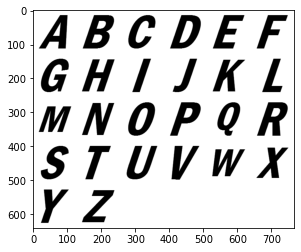

In [6]:
def get_image_shape():
    img = cv.imread(ROOT + 'A/img011-00001.png', 0)
    return img.shape


img_shape = get_image_shape()
print('Image shape: ', img_shape)
gesture_data = os.listdir(ROOT)
num_g = len(gesture_data)
print('Number of letters: ', num_g)

num_cols = 6
num_rows = int(num_g/num_cols)

if(num_g%num_cols):
    num_rows+=1

print('Number of rows: ', num_rows)

begin = 0
final_img = None

for i in range(num_rows):
    row_img = None
    for j in range(begin, begin+num_cols):
        if (j>= num_g):
            img = np.zeros(img_shape, dtype = np.uint8)
            img[:,:] = 255
            #print('Image index: ', j, 'false')
            
        else:         
            imgpath = ROOT + reverselookup[j] + '/img0' + str(j+11) + '-00359' + '.png'
            img = cv.imread(imgpath, 0)
            #if not np.any(img == None):
                #print('Image index: ', j, 'true')
            
        if np.any(row_img == None):
            row_img = img
        else:
            row_img = np.hstack((row_img, img))
            
    begin += num_cols
    if np.any(final_img == None):
            final_img = row_img
    else:
        final_img = np.vstack((final_img, row_img))  
                        
plt.imshow(final_img, cmap='gray')
#cv.waitKey(0)
#cv.destroyAllWindows()        

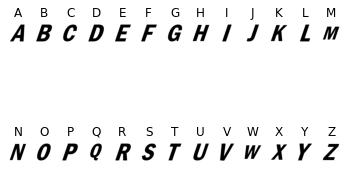

In [7]:
gestures = []
titles = []

for i in range(num_g):
    imgpath = ROOT + reverselookup[i] + '/img0' + str(i+11) + '-00359' + '.png'
    img = cv.imread(imgpath, 0)
    gestures.append(img)
    titles.append(reverselookup[i])
    
for i in range(num_g):
    plt.subplot(2, 13, i+1)
    plt.imshow(gestures[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

In [18]:
from torchvision import models
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

In [19]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
n_classes = 26

model.fc = nn.Sequential(
                      nn.Linear(512, 512), 
                      nn.ReLU(), 
                      nn.Linear(512, 512), 
                      nn.ReLU(),
                      nn.Dropout(0.3), 
                      nn.Linear(512, n_classes),                   
                      nn.LogSoftmax(dim=1))

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
total_params = sum(p.numel() for p in model.parameters())

print(f'{total_params:,} total parameters')

total_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'{total_trainable:,} trainable parameters.')

11,715,162 total parameters
538,650 trainable parameters.


In [22]:
# Move to gpu
model = model.to(device)
# Distribute across 2 gpus
model = nn.DataParallel(model)

loss_func = F.cross_entropy
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.999), lr = 0.001)


In [23]:
def accuracy(out, yb):
    pred = torch.argmax(out, keepdim= False, dim=1)
    return (pred == yb).float().mean() 

In [24]:
def fit(model, epochs, train_loader, valid_loader, opt):
    losses = []
    
    for epoch in range(epochs):
        train_loss =0
        train_acc =0
        model.train()
        for xb, yb in train_loader:
            xb =xb.to(device)
            yb = yb.to(device)
            pred = model(xb.float())
            pred.to(device)
            train_acc += accuracy(pred, yb)
            loss = loss_func(pred, yb)
            train_loss += loss
            #back propogation
            loss.backward()
            opt.step()
            opt.zero_grad()      

        losses.append(train_loss)
        print("Iteration no: "+ str(epoch+1), "loss = "+str(losses[epoch].item()))
        print("Accuracy of train set:", train_acc/len(train_loader))
        lr_scheduler.step(train_loss/len(train_loader))
        
        
        model.eval()    
        with torch.no_grad():
            valid_acc=0
            loss_valid = 0
            for xb_valid, yb_valid in valid_loader:
                xb_valid = xb_valid.to(device)
                yb_valid = yb_valid.to(device)
                pred_valid = model(xb_valid.float())
                pred_valid.to(device)
                valid_acc += accuracy(pred_valid, yb_valid)
                loss_valid += loss_func(pred_valid, yb_valid)
            print("Accuracy of validation set :", valid_acc/len(valid_loader))
            #callbacks = [EarlyStopping(monitor='valid_acc', verbose=False, mode='max', patience=10)]

    plt.plot(losses)
    plt.ylabel("loss")
    plt.xlabel("iterations")
    plt.show()

In [25]:
#model.set_callbacks(callbacks)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, verbose=True, eps = 10e-14)

Iteration no: 1 loss = 889.8927612304688
Accuracy of train set: tensor(0.6603, device='cuda:0')
Accuracy of validation set : tensor(0.8043, device='cuda:0')
Iteration no: 2 loss = 571.1222534179688
Accuracy of train set: tensor(0.7826, device='cuda:0')
Accuracy of validation set : tensor(0.8199, device='cuda:0')
Iteration no: 3 loss = 510.4540100097656
Accuracy of train set: tensor(0.8073, device='cuda:0')
Accuracy of validation set : tensor(0.8385, device='cuda:0')
Iteration no: 4 loss = 472.87847900390625
Accuracy of train set: tensor(0.8177, device='cuda:0')
Accuracy of validation set : tensor(0.8557, device='cuda:0')
Iteration no: 5 loss = 451.7557678222656
Accuracy of train set: tensor(0.8293, device='cuda:0')
Accuracy of validation set : tensor(0.8490, device='cuda:0')
Iteration no: 6 loss = 428.271728515625
Accuracy of train set: tensor(0.8365, device='cuda:0')
Accuracy of validation set : tensor(0.8750, device='cuda:0')
Iteration no: 7 loss = 416.9744873046875
Accuracy of train

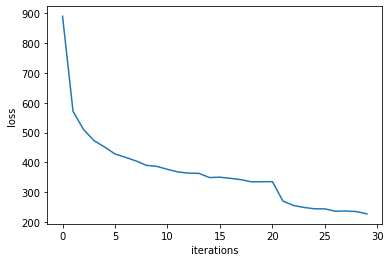

In [26]:
fit(model, 30, train_loader, valid_loader, optimizer)

In [27]:
torch.save(model, './gest_full_resnet18.pth')